### 1) Загрузите данные ex6data1.mat из файла.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '/home/ataleckij/Projects/university/mo/Data/Lab 6/'

In [3]:
files_names = os.listdir(DATA_PATH)
print(files_names)
files_paths = [os.path.join(DATA_PATH, name) for name in files_names]

['bird_small.mat', 'ex6data1.mat']


In [4]:
from scipy.io import loadmat

data = loadmat(files_paths[1])
bird_small = loadmat(files_paths[0])

X = data['X']
print(X.shape)

bird_small_img = bird_small['A'].reshape((128, 128, 3))
print(bird_small_img.shape)

(50, 2)
(128, 128, 3)


### 2) Реализуйте функцию случайной инициализации K центров кластеров.
### 3) Реализуйте функцию определения принадлежности к кластерам.
### 4) Реализуйте функцию пересчета центров кластеров.
### 5) Реализуйте алгоритм K-средних.

In [5]:
from functools import partial
from scipy.optimize import minimize

class KMEANS:
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self._clusters_centers_history = []
        self._clusters_centers = None
        self.history = []
    
    @staticmethod
    def get_closest_cluster(clusters_centers, x, norm='L2'):
        if norm == 'L2':
            return np.argmin(np.sqrt(np.sum((clusters_centers - x)**2, axis=1)))
        else:
            raise NotImplementedError()
    
    @staticmethod
    def calc_loss(clusters_centers, X, lambda_=0, predicted_clusters_indexes=None):
        clusters_centers = clusters_centers.reshape((-1, X.shape[1]))
        if predicted_clusters_indexes is None:
            predicted_clusters_indexes = [KMEANS.get_closest_cluster(clusters_centers, x) for x in X]
        predicted_clusters_centers = clusters_centers[predicted_clusters_indexes]
        return np.mean(np.sum((predicted_clusters_centers - X)**2, axis=1))
    
    def fit(self, X, random_state=42, optimizer='default', niters=10, save_history=True):
        best_loss, best_clusters_centers, best_history = np.inf, None, []
        for i in range(niters):
            assert self.n_clusters < X.shape[0]
            history = []
            rand = np.random.RandomState(i + random_state)
            clusters_centers_indexes = rand.choice(np.arange(X.shape[0]), self.n_clusters, replace=False)
            clusters_centers = X[clusters_centers_indexes]
            if optimizer == 'default':
                loss = np.inf
                while True:
                    predicted_clusters_indexes = [KMEANS.get_closest_cluster(clusters_centers, x) for x in X]
                    if save_history:
                        history.append((clusters_centers.copy(), predicted_clusters_indexes.copy()))
                    for cluster_index in np.unique(predicted_clusters_indexes):
                        clusters_centers[cluster_index] = X[predicted_clusters_indexes == 
                                                            cluster_index].mean(axis=0)
                    current_loss = self.calc_loss(clusters_centers, X, 
                                                  predicted_clusters_indexes=predicted_clusters_indexes)
                    if loss - current_loss <= 0.00001:
                        break
                    loss = current_loss
            else:
                calc_current_loss = partial(self.calc_loss, X=X)
                optimize_result = minimize(calc_current_loss, clusters_centers, method=optimizer)
                if optimize_result.success:
#                     print(optimize_result.nit)
                    clusters_centers = optimize_result.x.reshape((-1, X.shape[1]))
                else:
                    print(f'{optimizer} faled')
#                     raise NotImplementedError()
            current_loss = self.calc_loss(clusters_centers, X)
            if current_loss < best_loss:
                print(i, current_loss)
                best_loss, best_clusters_centers, best_history = current_loss, clusters_centers, history
        print(best_loss)
        self._clusters_centers = best_clusters_centers
        self.history = best_history
        return self
    
    def predict(self, X):
        predicted_clusters_indexes = [self.get_closest_cluster(self._clusters_centers, x) for x in X]
        return predicted_clusters_indexes
    
    def plot(self, X):
        predicted_clusters_indexes = self.predict(X)
        plt.scatter(X[:, 0], X[:, 1], c=predicted_clusters_indexes)
        plt.scatter(self._clusters_centers[:, 0], self._clusters_centers[:, 1], 
                    c=np.arange(self._clusters_centers.shape[0]), marker='x', 
                    s=1000)
        plt.show()


In [6]:
# from functools import partial
# from scipy.optimize import minimize

# class KMEANS_L2:
#     def __init__(self, n_clusters=5, l2=0):
#         self.n_clusters = n_clusters
#         self.l2 = l2
#         self._clusters_centers_history = []
#         self._clusters_centers = None
    
#     @staticmethod
#     def get_closest_cluster(clusters_centers, x, norm='L2'):
#         if norm == 'L2':
#             return np.argmin(np.sum((clusters_centers - x)**2, axis=1))
#         else:
#             raise NotImplementedError()
    
#     @staticmethod
#     def calc_loss(clusters_centers, X, lambda_=0, print_=False):
#         clusters_centers = clusters_centers.reshape((-1, X.shape[1]))
#         loss1 = loss2 = 0
#         for x in X:
#             predicted_clusters_index = KMEANS.get_closest_cluster(clusters_centers, x)
#             predicted_cluster_center = clusters_centers[predicted_clusters_index]
#             loss1 += np.sum((predicted_cluster_center - x)**2)
#             other_clusters_centers = np.delete(clusters_centers, predicted_clusters_index, axis=0)
#             other_cluster_loss = (np.sum((other_clusters_centers - x)**2, axis=1) / 
#                                   np.sum((other_clusters_centers - predicted_cluster_center)**2, axis=1))
#             loss2 -= np.mean(other_cluster_loss)
#         l2 = np.mean(np.sum(clusters_centers ** 2, axis=1))
#         if print_:
#             print(loss1 / (2 * X.shape[0]), loss2 / (2 * X.shape[0]), lambda_ * l2)
#         return (loss1 + loss2) / (2 * X.shape[0]) + lambda_ * l2
    
#     def fit(self, X, random_state=42, optimizer='default', niters=10):
#         best_loss, best_clusters_centers = np.inf, None
#         for i in range(niters):
#             assert self.n_clusters < X.shape[0]
#             rand = np.random.RandomState(i + random_state)
#             clusters_centers_indexes = rand.choice(np.arange(X.shape[0]), self.n_clusters, replace=False)
#             clusters_centers = X[clusters_centers_indexes]
#             if optimizer == 'default':
#                 loss = np.inf
#                 while True:
#                     pass
#             else:
#                 calc_current_loss = partial(self.calc_loss, X=X, lambda_=self.l2)
#                 optimize_result = minimize(calc_current_loss, clusters_centers, method=optimizer)
#                 if optimize_result.success:
#                     clusters_centers = optimize_result.x.reshape((-1, X.shape[1]))
#                 else:
#                     pass
# #                     raise NotImplementedError()
#             current_loss = self.calc_loss(clusters_centers, X, lambda_=self.l2)
#             if current_loss < best_loss:
#                 print(i, current_loss)
#                 current_loss = self.calc_loss(clusters_centers, X, print_=True, lambda_=self.l2)
#                 best_loss, best_clusters_centers = current_loss, clusters_centers
#         print(best_loss)
#         self._clusters_centers = best_clusters_centers
#         return self
    
#     def predict(self, X):
#         predicted_clusters_indexes = [self.get_closest_cluster(self._clusters_centers, x) for x in X]
#         return predicted_clusters_indexes
    
#     def plot(self, X):
#         predicted_clusters_indexes = self.predict(X)
#         plt.scatter(X[:, 0], X[:, 1], c=predicted_clusters_indexes)
#         plt.scatter(self._clusters_centers[:, 0], self._clusters_centers[:, 1], 
#                     c=np.arange(self._clusters_centers.shape[0]), marker='x', s=1000)
#         plt.show()


### 6) Постройте график, на котором данные разделены на K=3 кластеров (при помощи различных маркеров или цветов), а также траекторию движения центров кластеров в процессе работы алгоритма

In [7]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

0 0.6217136197659279
4 0.6217136197171818
6 0.6075013356233082
7 0.5927612625252869
12 0.5927612624625722
25 0.5927612624597602
84 0.5927612624596912
0.5927612624596912
[[4.34231606 5.29734997]
 [2.76928433 4.02273745]
 [5.45459269 6.16011726]]


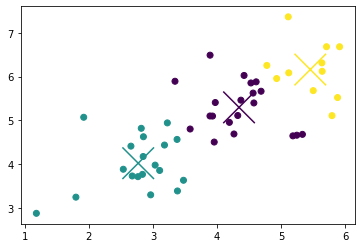

In [8]:
kmeans = KMEANS(n_clusters=3)
kmeans.fit(X, random_state=42, optimizer='BFGS', niters=100)  # Nelder-Mead
print(kmeans._clusters_centers)

kmeans.plot(X)

0 0.6145333635678035
6 0.6075013356086039
7 0.5927612624586157
0.5927612624586157
[[2.7692839  4.02273777]
 [5.45459288 6.16011729]
 [4.34231741 5.29734923]]


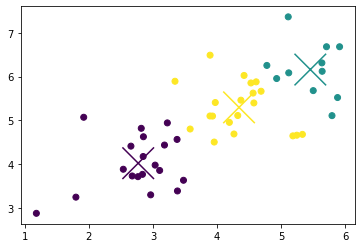

In [9]:
kmeans = KMEANS(n_clusters=3)
kmeans.fit(X, random_state=42, optimizer='default', niters=100)
print(kmeans._clusters_centers)

kmeans.plot(X)

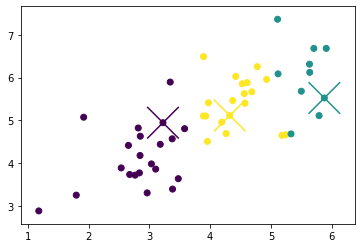

In [10]:
from matplotlib import cm
from celluloid import Camera

camera = Camera(plt.figure())
for clusters_centers, predicted_clusters_indexes in kmeans.history:
    for _ in range(2):
        plt.scatter(X[:, 0], X[:, 1], c=predicted_clusters_indexes)
        plt.scatter(clusters_centers[:, 0], clusters_centers[:, 1], 
                    c=np.arange(clusters_centers.shape[0]), marker='x', s=1000)
        camera.snap()
clusters_centers, predicted_clusters_indexes = kmeans.history[0]
plt.scatter(X[:, 0], X[:, 1], c=predicted_clusters_indexes)
plt.scatter(clusters_centers[:, 0], clusters_centers[:, 1], 
            c=np.arange(clusters_centers.shape[0]), marker='x', s=1000)
camera.snap()
        
anim = camera.animate(blit=True)
anim.save('./kmeans.mp4')

In [11]:
from IPython.display import Video

Video('./kmeans.mp4')

### 8) С помощью алгоритма K-средних используйте 16 цветов для кодирования пикселей.

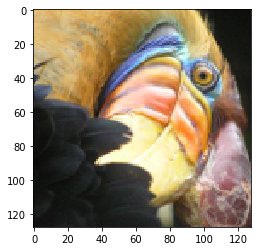

In [12]:
plt.imshow(bird_small_img)

In [118]:
from sklearn.preprocessing import MinMaxScaler

normer1 = MinMaxScaler()
bird_small_img_normed = normer1.fit_transform(bird_small_img.reshape((16384, 3))).reshape((128, 128, 3))

X1 = bird_small_img_normed.reshape((16384, 3))

kmeans = KMEANS(n_clusters=16)
kmeans.fit(X1, random_state=42, optimizer='default', niters=10)

0 0.008058229442727032
5 0.007817196700094595
0.007817196700094595


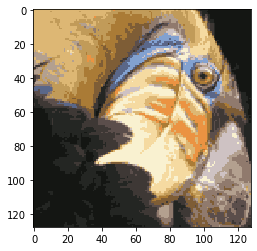

In [53]:
predicted_clusters_indexes = kmeans.predict(X1)
processed_bird_small_img = kmeans._clusters_centers[predicted_clusters_indexes]

processed_bird_small_img = normer1.inverse_transform(processed_bird_small_img).reshape((128, 128, 3)).astype('uint8')

plt.imshow(processed_bird_small_img)

In [60]:
import cv2

cv2.imwrite('bird_small_img.png', bird_small_img)
cv2.imwrite('processed_bird_small_img.png', processed_bird_small_img)

True

In [78]:
!ls -l | grep bird_small_img

-rw-r--r-- 1 ataleckij ataleckij  35220 дек 13 05:55 bird_small_img.png
-rw-r--r-- 1 ataleckij ataleckij  15768 дек 13 05:55 processed_bird_small_img.png


### 10) Реализуйте алгоритм K-средних на другом изображении.

(225, 225, 3)


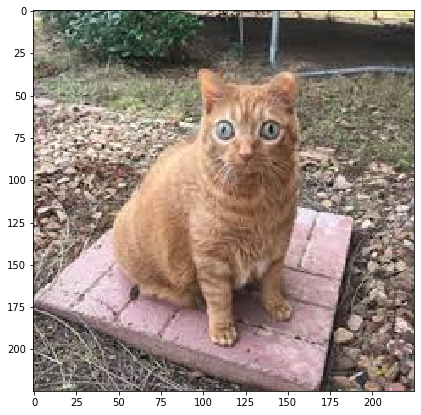

In [100]:
kk_img = cv2.imread('cat.png')
kk_img = cv2.cvtColor(kk_img, cv2.COLOR_BGR2RGB)

plt.subplots(figsize=(7, 7))
plt.imshow(kk_img)
print(kk_img.shape)

In [95]:
normer2 = MinMaxScaler()
X2 = normer2.fit_transform(kk_img.reshape((225*225, 3)))

kmeans = KMEANS(n_clusters=16)
kmeans.fit(X2, random_state=42, optimizer='default', niters=10)

0 0.0035036474840074525
0.0035036474840074525


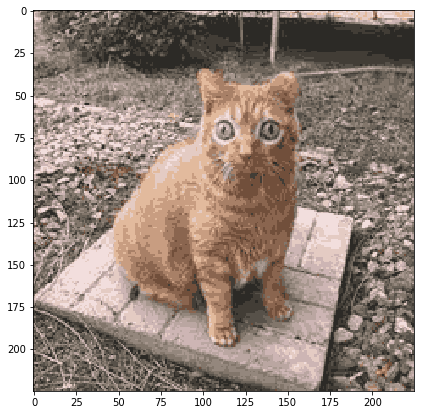

In [101]:
predicted_clusters_indexes = kmeans.predict(X2)
processed_kk_img = kmeans._clusters_centers[predicted_clusters_indexes]

processed_kk_img = normer2.inverse_transform(processed_kk_img).reshape((225, 225, 3)).astype('uint8')

plt.subplots(figsize=(7, 7))
plt.imshow(processed_kk_img)

In [102]:
from PIL import Image

Image.fromarray(processed_kk_img).save('processed_cat_img.png')

In [105]:
!ls -l | grep cat

-rw-r--r-- 1 ataleckij ataleckij 114895 дек 13 06:28 cat.png
-rw-r--r-- 1 ataleckij ataleckij  43243 дек 13 06:32 processed_cat_img.png


### 11 Реализуйте алгоритм иерархической кластеризации на том же изображении. Сравните полученные результаты.

In [112]:
from sklearn.cluster import AgglomerativeClustering

agg_clust = AgglomerativeClustering(n_clusters=16)
predicted_clusters_indexes = agg_clust.fit_predict(X1)

In [116]:
clusters_centers = np.array([X1[predicted_clusters_indexes == i].mean(axis=0) 
                             for i in range(16)])

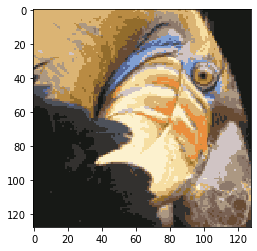

In [122]:
processed_bird_small_img = clusters_centers[predicted_clusters_indexes]
processed_bird_small_img = normer1.inverse_transform(processed_bird_small_img).reshape((128, 128, 3)).astype('uint8')

plt.imshow(processed_bird_small_img)

In [123]:
cv2.imwrite('processed_bird_small_img_agg.png', processed_bird_small_img)

!ls -l | grep bird_small_img

-rw-r--r-- 1 ataleckij ataleckij  35220 дек 13 05:55 bird_small_img.png
-rw-r--r-- 1 ataleckij ataleckij  14883 дек 13 06:44 processed_bird_small_img_agg.png
-rw-r--r-- 1 ataleckij ataleckij  15768 дек 13 05:55 processed_bird_small_img.png
